# Metro LA LTV Market Score Model 
This notebook calculates a market score and LTV cap for each ZIP Code in the Metro LA area using Redfin data and ACS income data, applying a framework with county-level lending risk profile adjustment and zip code market score adjustment.

In [1]:
# 1. Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. Load and Merge Datasets
df = pd.read_csv('zip_code_market_tracker.tsv000', sep='\t')
df['PERIOD_BEGIN'] = pd.to_datetime(df['PERIOD_BEGIN'])
df['ZIP'] = df['REGION'].str.extract(r'Zip Code: (\d{5})')
df = df[df['PERIOD_BEGIN'] == df['PERIOD_BEGIN'].max()]

metro_la = ['Los Angeles, CA', 'Orange County, CA', 'Ventura, CA', 'Riverside, CA', 'San Bernardino, CA']
df = df[df['PARENT_METRO_REGION'].isin(metro_la)]

income = pd.read_csv('ACSDT5Y2023.B06011-Data.csv')
income['ZIP'] = income['GEO_ID'].str.extract(r'(\d{5})$')
income = income.rename(columns={'B06011_001E': 'Median_Income'})[['ZIP', 'Median_Income']]

# Merge all datasets
df = df.merge(income, on='ZIP', how='left')

In [3]:
# 3. Market Score Calculation
df['score_sale_to_list'] = df['AVG_SALE_TO_LIST'].rank(pct=True)
df['score_homes_sold'] = df['HOMES_SOLD'].rank(pct=True)
df['score_dom'] = 1 - df['MEDIAN_DOM'].rank(pct=True)
df['score_income'] = df['Median_Income'].rank(pct=True)

df['market_score'] = 100 * (
    0.35 * df['score_sale_to_list'] +
    0.35 * df['score_homes_sold'] +
    0.15 * df['score_dom'] +
    0.15 * df['score_income']
)

In [4]:
# 5. Classify and Adjust LTV
def classify_market(score):
    if score >= 70:
        return 'Prime'
    elif score <= 35:
        return 'Declining'
    return 'Neutral'

df['market_category'] = df['market_score'].apply(classify_market)

In [5]:
# 6. Apply LTV Adjustment Framework

# County-level lending risk profile adjustment
county_adj = {
    'Los Angeles, CA': -2,
    'Orange County, CA': 0,
    'Ventura, CA': -1,
    'Riverside, CA': -1,
    'San Bernardino, CA': -1
}

# Zip code market score adjustment
score_adj = {'Prime': 2, 'Declining': -5, 'Neutral': 0}

df['county_adj'] = df['PARENT_METRO_REGION'].map(county_adj)
df['score_adj'] = df['market_category'].map(score_adj)

df['base_ltv'] = 70
df['max_ltv'] = df['base_ltv'] + df['county_adj'] + df['score_adj']
df['max_ltv'] = df['max_ltv'].clip(60, 75)

# Visualization

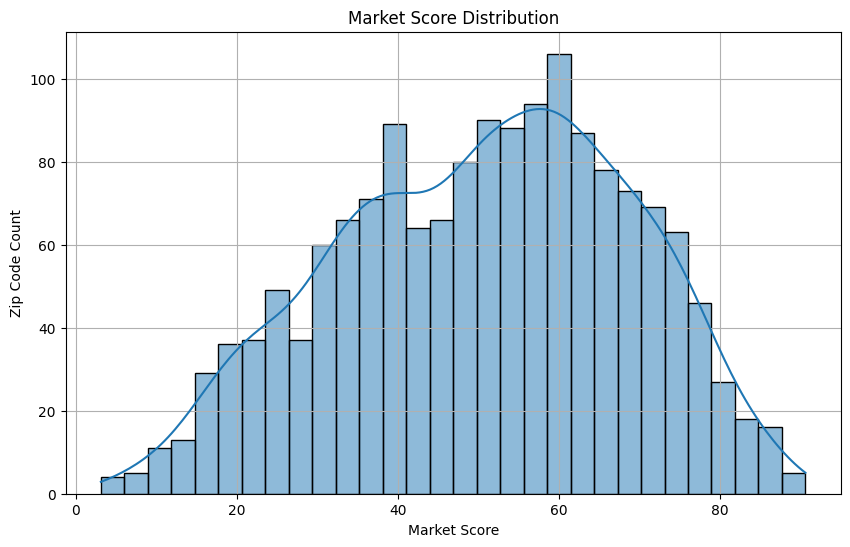

In [6]:
# 7. Market Score Distribution
plt.figure(figsize=(10,6))
sns.histplot(df['market_score'], bins = 30, kde = True)
plt.title('Market Score Distribution')
plt.xlabel('Market Score')
plt.ylabel('Zip Code Count')
plt.grid(True)
plt.show()

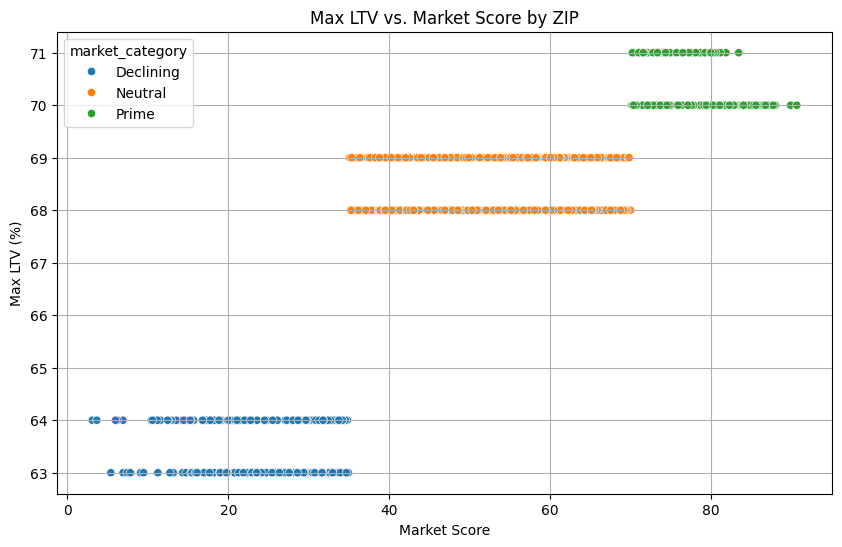

In [7]:
# Max LTV vs Market Score Scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='market_score', y='max_ltv', hue='market_category')
plt.title('Max LTV vs. Market Score by ZIP')
plt.xlabel('Market Score')
plt.ylabel('Max LTV (%)')
plt.grid(True)
plt.show()

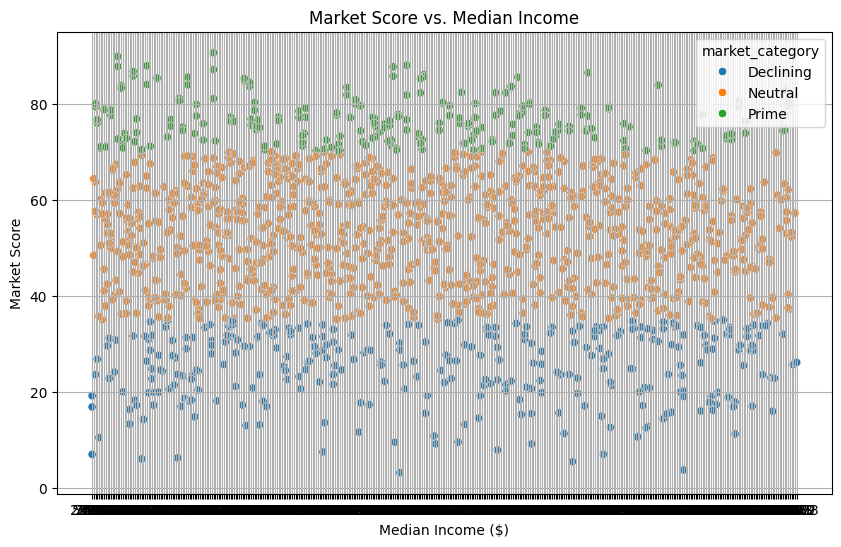

In [8]:
# Median Income vs. Market Score Scatterplot
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Median_Income', y='market_score', hue='market_category')
plt.title('Market Score vs. Median Income')
plt.xlabel('Median Income ($)')
plt.ylabel('Market Score')
plt.grid(True)
plt.show()

In [10]:
# 8. Top/Bottom 10 Zip Codes
top10 = df.sort_values('market_score', ascending=False).head(10)
bottom10 = df.sort_values('market_score').head(10)
display(top10[['ZIP', 'market_score', 'max_ltv', 'market_category', 'Median_Income']])
display(bottom10[['ZIP', 'market_score', 'max_ltv', 'market_category', 'Median_Income']])

,ZIP,market_score,max_ltv,market_category,Median_Income
1405,91105,90.632837,70,Prime,91447
1091,91107,89.857511,70,Prime,57509
240,91030,88.011395,70,Prime,73363
402,90066,87.920905,70,Prime,60593
140,91107,87.766731,70,Prime,57509
1063,90405,87.697535,70,Prime,75495
84,91105,87.119197,70,Prime,91447
1264,91214,86.746270,70,Prime,62194
476,90402,86.463259,70,Prime,91710
257,91104,86.102100,70,Prime,47648


,ZIP,market_score,max_ltv,market_category,Median_Income
510,92225,3.098430,64,Declining,22621
1284,92333,3.662222,64,Declining,-
755,90057,5.405361,63,Declining,27087
924,92301,5.988115,64,Declining,29543
56,92240,6.216520,64,Declining,29665
0,92254,6.906933,64,Declining,23840
1227,91204,6.928825,63,Declining,29555
1359,90011,7.435870,63,Declining,24657
1420,90270,7.839772,63,Declining,28035
749,90304,9.102022,63,Declining,29213


In [13]:
# 9. Export Results to a .csv File
summary = df[['ZIP', 'PARENT_METRO_REGION', 'market_score', 'market_category', 'Median_Income',
              'county_adj', 'score_adj', 'max_ltv', 'MEDIAN_SALE_PRICE', 'HOMES_SOLD', 'MEDIAN_DOM']]
summary.to_csv('Metro_LA_LTV_Scores.csv', index=False)
summary.head()

,ZIP,PARENT_METRO_REGION,market_score,market_category,Median_Income,county_adj,score_adj,max_ltv,MEDIAN_SALE_PRICE,HOMES_SOLD,MEDIAN_DOM
0,92254,"Riverside, CA",6.906933,Declining,23840,-1,-5,64,320000.0,1.0,77.0
1,92508,"Riverside, CA",64.254836,Neutral,54421,-1,0,69,730000.0,86.0,48.0
2,90277,"Los Angeles, CA",63.713552,Neutral,78560,-2,0,68,985000.0,15.0,26.5
3,91790,"Los Angeles, CA",56.861415,Neutral,36732,-2,0,68,787521.0,7.0,24.0
4,92252,"Riverside, CA",35.740696,Neutral,29443,-1,0,69,401750.0,64.0,114.0
